# **FIFA ANALYTICS**

#### **AVULA BHUMIKA**

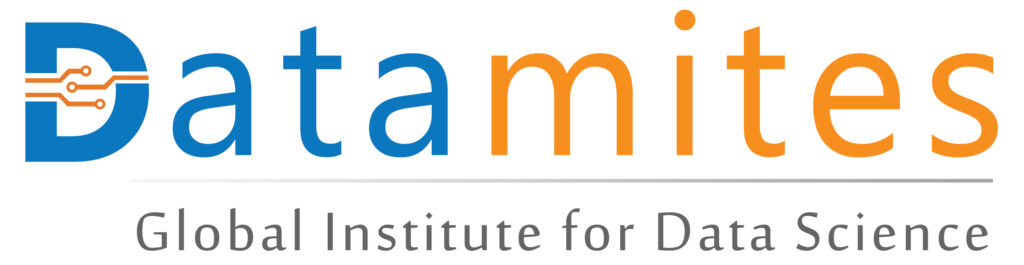

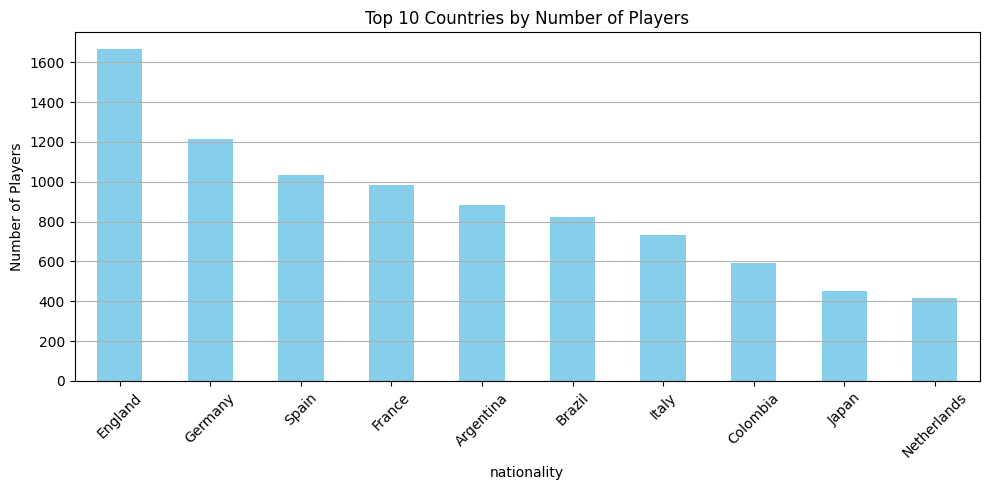

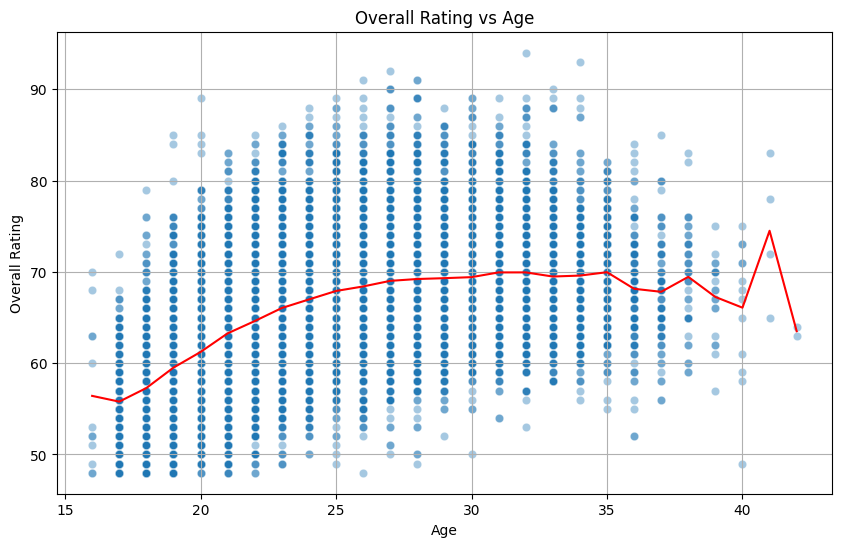

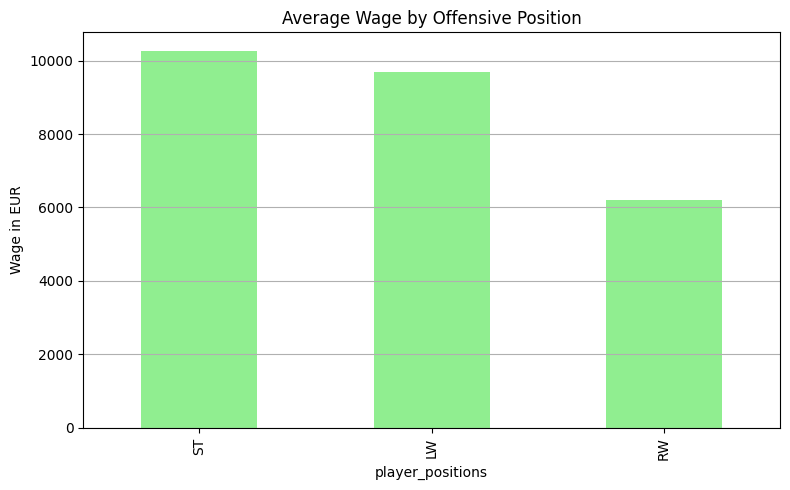

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from warnings import filterwarnings
filterwarnings('ignore')

df = pd.read_csv("players_20.csv")

df[['AttackWorkRate', 'DefenseWorkRate']] = df['work_rate'].str.split('/', expand=True)
rate_map = {'Low': 0, 'Medium': 0.5, 'High': 1}
df['AttackWorkRate'] = df['AttackWorkRate'].map(rate_map)
df['DefenseWorkRate'] = df['DefenseWorkRate'].map(rate_map)

# Top 10 Countries with Most Players 
top_countries = df['nationality'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_countries.plot(kind='bar', color='skyblue')
plt.title("Top 10 Countries by Number of Players")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Distribution of Overall Rating vs Age 
plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='overall', data=df, alpha=0.4)
sns.lineplot(x='age', y='overall', data=df.groupby('age')['overall'].mean().reset_index(), color='red')
plt.title("Overall Rating vs Age")
plt.xlabel("Age")
plt.ylabel("Overall Rating")
plt.grid(True)
plt.show()

# Offensive Players and Their Wages
offensive_roles = ['ST', 'RW', 'LW']
df_offense = df[df['player_positions'].isin(offensive_roles)]
avg_wages = df_offense.groupby('player_positions')['wage_eur'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
avg_wages.plot(kind='bar', color='lightgreen')
plt.title("Average Wage by Offensive Position")
plt.ylabel("Wage in EUR")
plt.grid(axis='y')
plt.tight_layout()
plt.show()




## Additional Analysis

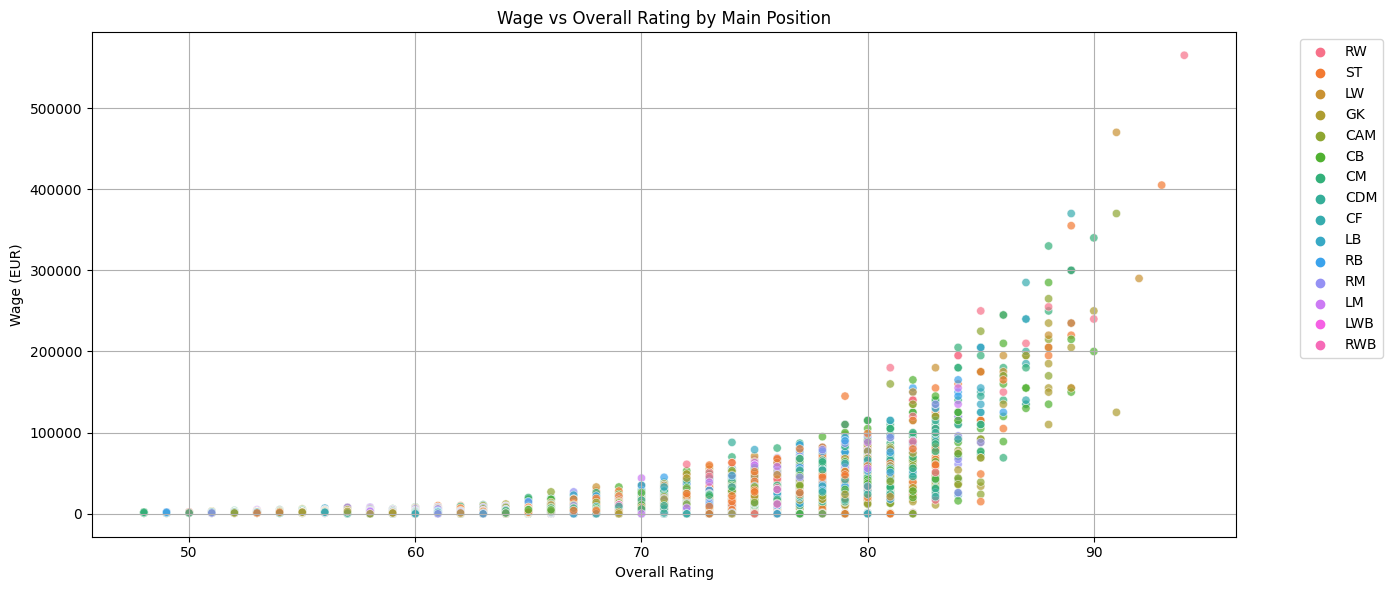

In [7]:
# Wage vs. Overall Skill by Position Category

df['main_position'] = df['player_positions'].str.split(',').str[0]

plt.figure(figsize=(14, 6))
sns.scatterplot(data=df, x='overall', y='wage_eur', hue='main_position', alpha=0.7)
plt.title("Wage vs Overall Rating by Main Position")
plt.xlabel("Overall Rating")
plt.ylabel("Wage (EUR)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
## Age vs. Potential: Identifying Rising Stars
young_stars = df[(df['age'] <= 23) & (df['potential'] - df['overall'] >= 10)]
top_young_stars = young_stars[['short_name', 'age', 'overall', 'potential', 'club']].sort_values(by='potential', ascending=False).head(10)
print(top_young_stars)


         short_name  age  overall  potential                  club
411      João Félix   19       80         93       Atlético Madrid
568    Vinícius Jr.   18       79         92           Real Madrid
1254       P. Foden   19       76         90       Manchester City
2121  D. Szoboszlai   18       74         89  FC Red Bull Salzburg
1615      S. Tonali   19       75         89               Brescia
1255        M. Kean   19       76         89               Everton
1256        Rodrygo   18       76         89           Real Madrid
753        A. Meret   22       78         89                Napoli
570   Lucas Paquetá   21       79         89                 Milan
569    R. Bentancur   22       79         89              Juventus


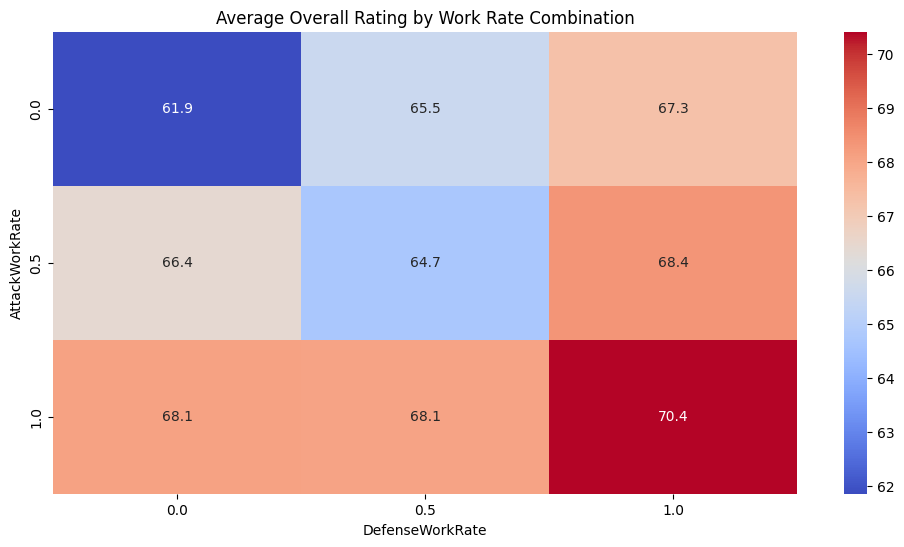

In [11]:
### Work Rate Impact on Performance
workrate_group = df.groupby(['AttackWorkRate', 'DefenseWorkRate'])['overall'].mean().reset_index()

plt.figure(figsize=(12, 6))
pivot = workrate_group.pivot(index='AttackWorkRate', columns='DefenseWorkRate', values='overall')
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Average Overall Rating by Work Rate Combination")
plt.show()


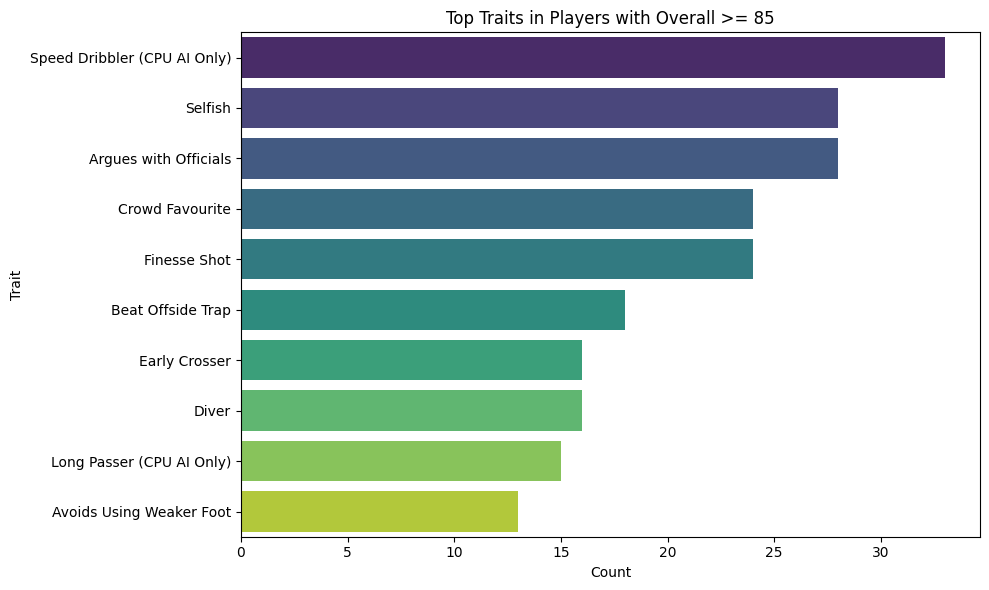

In [13]:
### Trait Distribution Across Top Players
top_players = df[df['overall'] >= 85]
traits_series = top_players['player_traits'].dropna().str.split(',').explode().str.strip()
top_traits = traits_series.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_traits.index, x=top_traits.values, palette='viridis')
plt.title("Top Traits in Players with Overall >= 85")
plt.xlabel("Count")
plt.ylabel("Trait")
plt.tight_layout()
plt.show()


### Clustering Model Build

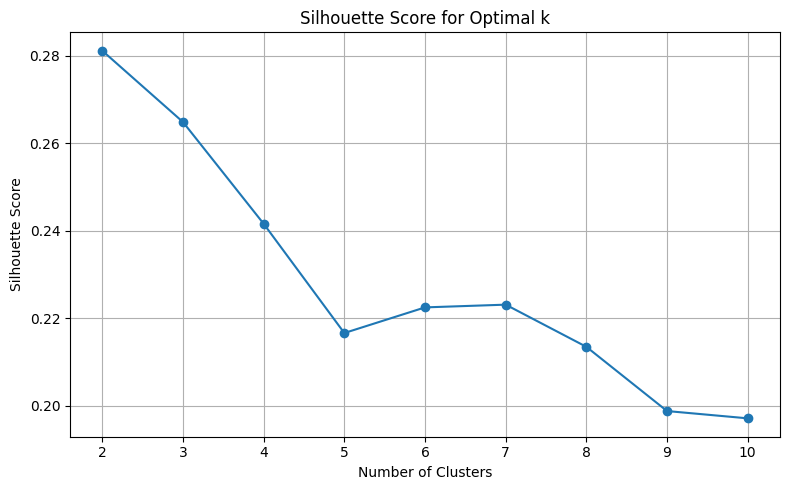

Optimal number of clusters: 2

Cluster Profiles:
               pace   shooting    passing  dribbling  defending     physic
cluster                                                                  
0        71.893249  60.172825  61.790891  68.087940  47.078106  63.731309
1        60.090137  38.002947  48.960825  52.444618  59.678107  66.955972


In [19]:
from sklearn.metrics import silhouette_score

skill_cols = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
df_clustering = df[skill_cols].dropna()
clustering_df = df.loc[df_clustering.index] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.tight_layout()
plt.show()

optimal_k = K_range[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters: {optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clustering_df['cluster'] = kmeans_final.fit_predict(X_scaled)

cluster_profile = clustering_df.groupby('cluster')[skill_cols].mean()
print("\nCluster Profiles:\n", cluster_profile)

## Visualise the Cluster to check Purity

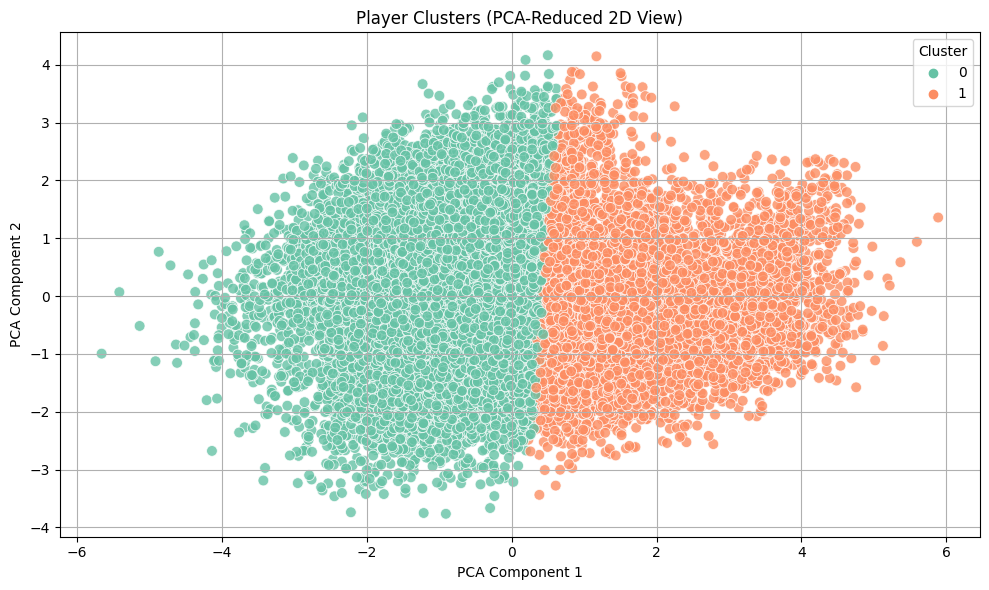

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

clustering_df['PCA1'] = X_pca[:, 0]
clustering_df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustering_df, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=60, alpha=0.8)
plt.title("Player Clusters (PCA-Reduced 2D View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


# **END**